#### SANDBOX for code development

In [37]:
#import packages
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import re
import seaborn as sns
from tqdm import tqdm_notebook

#import custom modules
import prep.prep_data as prep
import prep.prep_cv as cv
import model.fuzzy as fz
import semantic.semantic as sem

#magik
%matplotlib inline

In [38]:
#setup globals
#setup directories
CWD = os.getcwd()
HOME_DIR = os.path.abspath(os.path.join(CWD, os.pardir))
DATA_DIR = HOME_DIR + "/data"
DATA_FILENAME = "housing_data.csv"
RESULTS_DIR = HOME_DIR + "/results"

#setup lists of vars to work with
STR_VARS = ['housing_roof', 'housing_wall', 'housing_floor']
NUM_VARS = [s + '_num' for s in STR_VARS]
RANK_VARS = [s + '_rank' for s in STR_VARS]

#which variable do you want to predictn (currently: floor/wall/roof)
DEP_VAR = "housing_roof"
PRED_VAR = DEP_VAR + "_rank" #will always be using the strings to predict ranking

#setup a filter to select which surveys you want to work with
SVY_FILTER = ['MACRO_DHS']

#analytical options
CV_SAMPLE_PCT = .2 #hold out x% for testing
CV_SAMPLE_WT = "N" #which variable, if any, do you want to use to weight your test sample
CV_FOLDS = 3 #use a x-fold cross-validation env

#garbage lists
STR_GARBAGE = ['nan', 'other', 'not a dejure resident', 'not dejure resident']
RANK_GARBAGE = ['4', '5', '6', '7', '8', '9', 'n']

#dictionaries
PRED_DICT = {'natural':'1', 'rudimentary':'2', 'finished':'3'} #map categories back to ranks

In [39]:
df = prep.read_then_clean(DATA_DIR + "/" + DATA_FILENAME, STR_VARS, SVY_FILTER)

~begin reading
data read!
~begin cleaning
data clean!
~applying filter


In [40]:
df_clean = prep.remove_garbage_codes(df, STR_VARS, STR_GARBAGE)
df_clean = prep.extract_ranking(df_clean, NUM_VARS)
df_clean = prep.remove_garbage_codes(df_clean, RANK_VARS, RANK_GARBAGE)
df_clean = df_clean.dropna(subset=[DEP_VAR])
df_clean = sem.filter_one_word_materials(df_clean, DEP_VAR)
df_clean = df_clean[df_clean[DEP_VAR].isin(sem.check_if_english(df_clean,DEP_VAR))]
train_list = cv.cv_censor_col(df_clean, PRED_VAR, CV_SAMPLE_PCT, CV_SAMPLE_WT, CV_FOLDS)

{'nan': nan, 'other': nan, 'not a dejure resident': nan, 'not dejure resident': nan}
removing garbage from  housing_roof
removing garbage from  housing_wall
removing garbage from  housing_floor
defining ranking for  housing_roof_num
defining ranking for  housing_wall_num
defining ranking for  housing_floor_num
{'4': nan, '5': nan, '6': nan, '7': nan, '8': nan, '9': nan, 'n': nan}
removing garbage from  housing_roof_rank
removing garbage from  housing_wall_rank
removing garbage from  housing_floor_rank
sampling df, iteration # 0
sampling df, iteration # 1
sampling df, iteration # 2


In [44]:
cv_list = train_list
base_var = DEP_VAR
rank_dictionary = PRED_DICT
subset = None

In [45]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd
import numpy as np

#import custom modules
import semantic.semantic as sem
import model.fuzzy as fz
    
#setup objects
rank_var = base_var + '_rank'
og_var = rank_var + '_og'
    

rank_values = list(rank_dictionary.values())
rank_keys = list(rank_dictionary.keys())
    
#create lists to store loop outputs
cv_distrib = []
    
#loop over each cross validation:
for i in range(len(cv_list)):
        
    print('working on cv loop #', i)
    df = cv_list[i].copy() #subset the cv list to the current df

    #build corpus of known and unknown strings
    str_list, idk_strings = fz.build_corpus(df, base_var, rank_var, rank_values)
    str_list_unique = []
    for x in range(3):
        str_list_unique.append(np.unique(str_list[x]))
    #subset the unknown strings to allow for faster testing
    if subset != None:
        idk_strings = idk_strings[subset]
        
    #find distribution of scores for each string
    distrib = sem.semantic_similarity_scan(idk_strings, str_list_unique)
      
    
    #append results to prep for next loop
    cv_distrib.append(distrib)

working on cv loop # 0
building corpus for rank # 1
building corpus for rank # 2
building corpus for rank # 3
extracting unknown strings
need to classify 33 unknown strings
analyzing... metal
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... cement
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... wood
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... cardboard
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... slate
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... vegetal
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... sod
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... straw
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... tole
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... earth
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... leaves
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... tile
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... tin
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... concrete
~>corpus# 0
~>corpus# 1
~>corpus# 2
analyzing... calamine
~>corpus# 0
~>corpus# 1
~>corpu

In [51]:
gp_distrib = distrib.groupby('word').sum()
gp_distrib['sum_score'] = gp_distrib['natural'] + gp_distrib['rudimentary'] + gp_distrib['finished']
gp_distrib_sub = gp_distrib [gp_distrib.sum_score != 0]
list_non_zero = list(gp_distrib_sub.index)

In [52]:
distrib_plot = distrib[distrib['word'].isin(list_non_zero)]

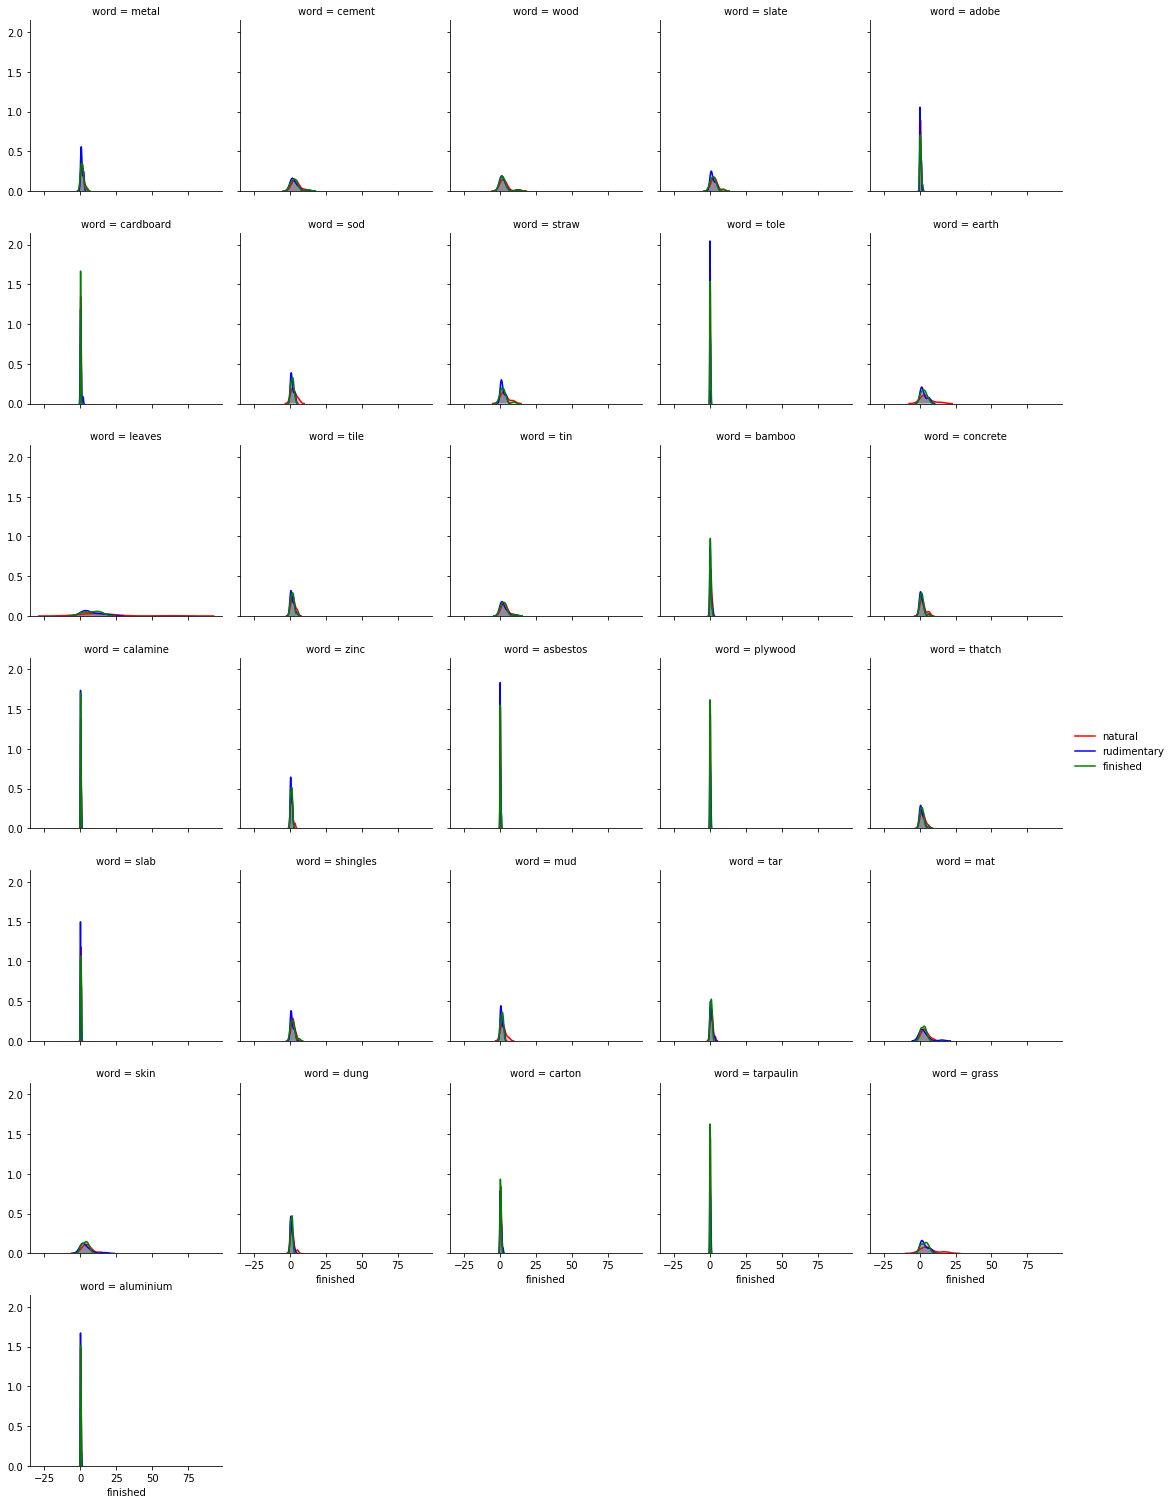

In [54]:
fz.fuzzy_density(distrib_plot, 'word', 
                 ['natural', 'rudimentary', 'finished'],
                 color_list={'natural':'r', 'rudimentary':'b', 'finished':'g'})